# Overview
- segmentにラベル付けしていくときの管理方法の実験

# Const

# Import everything I need :)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import librosa

/home/user/.local/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# Function

In [2]:
def feature_extraction(wav):
    feats = librosa.feature.mfcc(wav, sr=sr, n_fft=2048, hop_length=1024, n_mels=12).T
    feat_names = [f'mfcc_{i+1}' for i in range(feats.shape[1])]
    return feats, feat_names

# Prepation

In [3]:
path = librosa.util.example_audio_file()
wav, sr = librosa.load(path, sr=None)

<br>

valilables

In [4]:
df_label = pd.DataFrame({'label_pos': [[1.1, 2.62]], 'class': 'posi'})
df_label

,label_pos,class
0,"[1.1, 2.62]",posi


# Experiment
- セグメントとラベルの管理をシミュレーションしてみる

Text(0.5, 0, 'recording time [sec]')

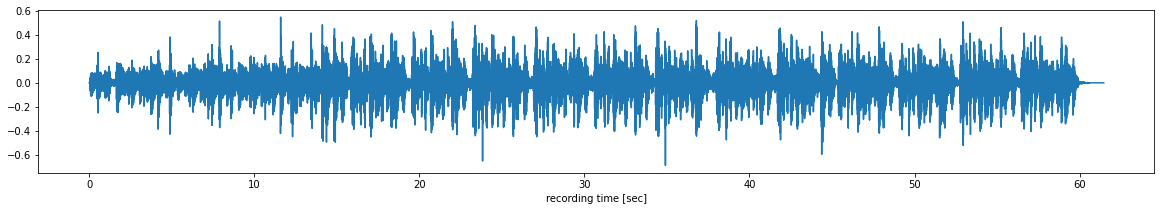

In [5]:
x_sec = (np.arange(0, len(wav))/sr)[::100]
plt.figure(figsize=(20, 3))
plt.plot(x_sec, wav[::100])
plt.xlabel('recording time [sec]')

<br>

1.4 ~ 2.62 秒に最初のラベルを付けたとする

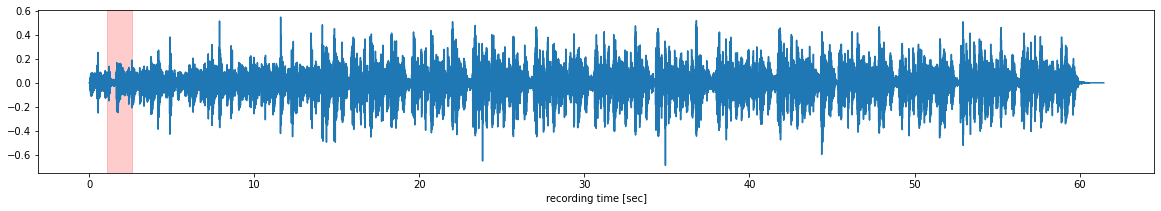

In [6]:
lbl_pos = df_label['label_pos'].values[0]

x_sec = (np.arange(0, len(wav))/sr)[::100]
fig, axs = plt.subplots(figsize=(20, 3))
axs.plot(x_sec, wav[::100])
axs.set_xlabel('recording time [sec]')
axs.axvspan(lbl_pos[0], lbl_pos[1], color='r', alpha=0.2)

<br>

- 1.4~2.62 にposiラベルが振られた。
- なので、2.62-1.1 ~ 1.5 秒のセグメントを作成

In [7]:
seg_len_sec = round(lbl_pos[1]-lbl_pos[0], 1)
seg_len_sec

1.5

<br>

セグメントを図にしてみる

In [8]:
n_seg = int(round(len(wav)/sr/seg_len_sec, 0))
n_seg

41

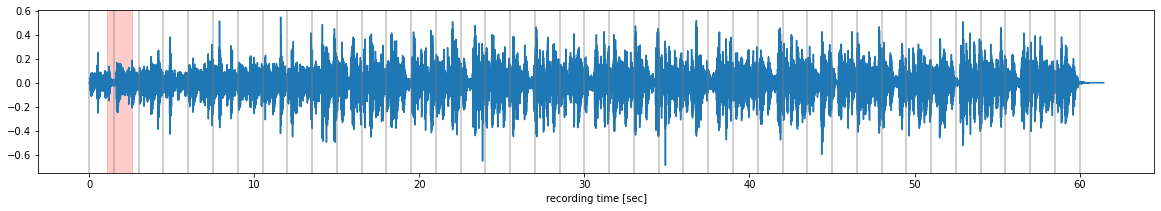

In [9]:
lbl_pos = df_label['label_pos'].values[0]

x_sec = (np.arange(0, len(wav))/sr)[::100]
fig, axs = plt.subplots(figsize=(20, 3))
axs.plot(x_sec, wav[::100])
axs.set_xlabel('recording time [sec]')
axs.axvspan(lbl_pos[0], lbl_pos[1], color='r', alpha=0.2)

# show segment
for i in range(n_seg):
    seg_start = i * seg_len_sec
    axs.axvline(seg_start, color='gray', alpha=0.5)

--> 赤い領域は、posiクラスとなる。  
--> 赤い領域とかぶっている部分はあまりの部分だけで特徴量を作成する

<br>

セグメントの管理を行う  
- 以下を見ればよくわかると思う

In [10]:
seg_starts_sec = []
for i in range(n_seg):
    seg_start = i * seg_len_sec
    seg_starts_sec.append(seg_start)
seg_starts_sec = np.array(seg_starts_sec)

In [11]:
feat_names = [f'mfcc_{i+1}' for i in range(12)]

In [12]:
df_seg = pd.DataFrame(seg_starts_sec, columns=['seg_start_sec'])
df_seg['label'] = 'None'
df_seg.head()

,seg_start_sec,label
0,0.0,None
1,1.5,None
2,3.0,None
3,4.5,None
4,6.0,None


In [58]:
n_fft = int(sr/10)
hop_length = int(n_fft/2)
df_feats = pd.DataFrame(columns=feat_names)
for i in range(n_seg):
    seg_start_sec = df_seg['seg_start_sec'].values[i]
    seg_end_sec = seg_start_sec + seg_len_sec
    
    # feats
    time = np.arange(0, len(wav))/sr
    idxs = (seg_start_sec <= time) & (time < seg_end_sec)
    feats = librosa.feature.mfcc(
                            y=wav[idxs],
                            sr=sr,
                            n_mels=12,
                            n_fft=n_fft,
                            hop_length=hop_length)
    feats = pd.DataFrame(feats.T).mean(axis=0).values
    _df_feats = pd.DataFrame([feats], columns=feat_names)
    df_feats = pd.concat([df_feats, _df_feats], axis=0)

# df_seg = df_seg.reset_index(drop=True)
display(df_feats.head())
display(df_seg.head())

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,-121.382378,81.705261,15.394197,-5.457198,2.646890,4.583136,1.739648,1.566029,0.886293,-0.136976,0.419849,0.737256
0,-122.982231,83.477051,19.470881,-3.812501,2.157793,5.533654,3.369894,2.971601,2.627065,2.008113,2.466947,2.213702
0,-113.991417,81.620819,19.369846,-1.211218,3.789957,4.815419,3.488543,3.109688,1.868053,1.550338,1.897059,1.135719
0,-107.093002,85.660744,13.050394,-7.342287,3.230472,4.630537,1.956431,2.725348,1.094955,-0.788532,-0.372970,-0.036502
0,-113.811707,77.330353,18.463524,-0.287426,4.009253,6.868976,3.527700,3.814207,4.490289,2.967824,1.251306,0.940458


,seg_start_sec,label
0,0.0,None
1,1.5,None
2,3.0,None
3,4.5,None
4,6.0,None


<br>

scaler

In [14]:
scaler = StandardScaler()
scaler.fit(df_feats)
feats = scaler.transform(df_feats)
df_feats = pd.DataFrame(feats, columns=feat_names)
df_seg = pd.concat([df_seg, df_feats], axis=1)
df_seg.head()

,seg_start_sec,label,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,0.0,None,-1.069150,1.597200,1.014141,-2.563975,0.064174,-0.331963,-1.147961,-1.517666,0.192541,0.498073,0.687131,-0.461132
1,1.5,None,-1.114999,1.743413,1.732092,-2.241980,-0.051423,0.313475,-0.519218,-0.907314,1.589414,1.273767,1.969584,1.591860
2,3.0,None,-0.857342,1.590231,1.714298,-1.732707,0.334335,-0.174234,-0.473458,-0.847352,0.980348,1.108229,1.612564,0.092930
3,4.5,None,-0.659648,1.923618,0.601371,-2.933033,0.202102,-0.299776,-1.064353,-1.014246,0.359981,0.262461,0.190450,-1.537039
4,6.0,None,-0.852191,1.236169,1.554685,-1.551849,0.386165,1.220210,-0.458356,-0.541424,3.084546,1.620812,1.208016,-0.178581


---> これで、準備ができた。  
---> つぎに、最初のラベルが振られたときをシミュレーションしてみる。  

<br>

下図を再掲する  

- 赤い部分がpositiveクラスである。  
- 1.1~2.62の赤い領域に、segment_start_sec=1.5 が含まれているので、これを削除。

before
```
seg_start_sec, class
0.0, None
1.5, None
3.0, None
4.5, None
.
.
.
```

after
```
seg_start_sec, class
0.0, None
1.1, Positive
2.62, Negative
3.0, None
4.5, None
```

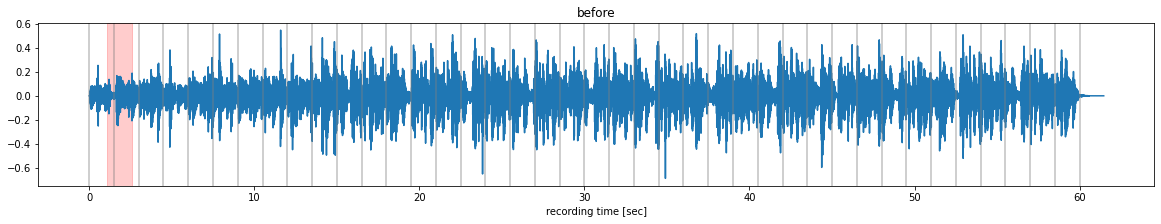

In [15]:
# beforeの図

lbl_pos = df_label['label_pos'].values[0]

x_sec = (np.arange(0, len(wav))/sr)[::100]
fig, axs = plt.subplots(figsize=(20, 3))
axs.set_title('before')
axs.plot(x_sec, wav[::100])
axs.set_xlabel('recording time [sec]')
axs.axvspan(lbl_pos[0], lbl_pos[1], color='r', alpha=0.2)

# show segment
for i in range(n_seg):
    seg_start = i * seg_len_sec
    axs.axvline(seg_start, color='gray', alpha=0.5)

<br>

ラベルの更新

In [16]:
start_sec = lbl_pos[0]
end_sec = lbl_pos[1]

seg_starts_sec = df_seg['seg_start_sec'].values
idxs = (start_sec <= seg_starts_sec) & (seg_starts_sec < end_sec)
df_seg = df_seg[np.logical_not(idxs)]

In [17]:
_df = pd.DataFrame({
    'seg_start_sec': [lbl_pos[0], lbl_pos[1]],
    'label': ['Positive', 'Negative']
})

In [18]:
df_seg = pd.concat([df_seg, _df], axis=0).sort_values('seg_start_sec')
df_seg = df_seg.reset_index(drop=True)
df_seg.head(10)

,seg_start_sec,label,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,0.00,None,-1.069150,1.597200,1.014141,-2.563975,0.064174,-0.331963,-1.147961,-1.517666,0.192541,0.498073,0.687131,-0.461132
1,1.10,Positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.62,Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.00,None,-0.857342,1.590231,1.714298,-1.732707,0.334335,-0.174234,-0.473458,-0.847352,0.980348,1.108229,1.612564,0.092930
4,4.50,None,-0.659648,1.923618,0.601371,-2.933033,0.202102,-0.299776,-1.064353,-1.014246,0.359981,0.262461,0.190450,-1.537039
5,6.00,None,-0.852191,1.236169,1.554685,-1.551849,0.386165,1.220210,-0.458356,-0.541424,3.084546,1.620812,1.208016,-0.178581
6,7.50,None,0.764356,-1.524865,1.283809,0.964827,-1.468938,-1.991814,-0.684057,-0.724162,-0.563172,0.415368,0.471441,-0.703741
7,9.00,None,0.576804,-2.126548,1.268093,1.366067,-1.290966,-1.500327,-0.017062,0.243584,2.161758,1.692177,1.460255,0.203271
8,10.50,None,0.579417,-1.914026,1.315609,1.351387,-1.310292,-0.987585,0.062989,-0.089123,1.040810,1.019912,0.973860,0.212007
9,12.00,None,0.966897,-1.467354,0.697123,0.208445,-1.691151,-0.514812,0.082706,-0.555552,-0.742188,0.481439,0.666966,0.014790


↑ 1.10の前、2.62の後の特徴量は再計算が必用なため、NaNにする

In [19]:
seg_starts_sec = df_seg['seg_start_sec'].values

idxs = seg_starts_sec == lbl_pos[0]
idx_before = df_seg[idxs].index.values[0] - 1
sec_before = df_seg.iloc[idx_before, :]['seg_start_sec']

idxs = seg_starts_sec == lbl_pos[1]
idx_after = df_seg[idxs].index.values[0] + 1
sec_after = df_seg.iloc[idx_after, :]['seg_start_sec']

# 領域前後のセグメントを削除
df_seg = df_seg.drop(index=[idx_before, idx_after])

# 領域前後の要素を挿入(特徴量はNaNになる)
_df = pd.DataFrame(
    {'seg_start_sec': [sec_before, sec_after],
     'label': ['None', 'None']
    })
df_seg = pd.concat([df_seg, _df]).sort_values('seg_start_sec')
df_seg = df_seg.reset_index(drop=True)

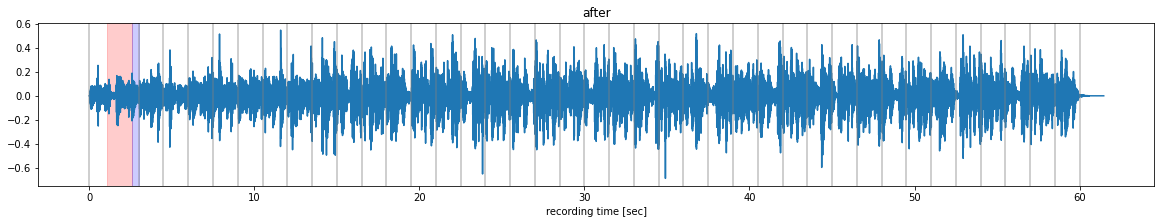

In [22]:
# afterの図

lbl_pos = df_label['label_pos'].values[0]

x_sec = (np.arange(0, len(wav))/sr)[::100]
fig, axs = plt.subplots(figsize=(20, 3))
axs.set_title('after')
axs.plot(x_sec, wav[::100])
axs.set_xlabel('recording time [sec]')

# show segment
for i in range(len(df_seg)):
    start_sec = df_seg['seg_start_sec'].values[i]
    label = df_seg['label'].values[i]
    
    if label == 'Positive':
        end_sec = df_seg['seg_start_sec'].values[i+1]
        axs.axvspan(start_sec, end_sec, color='r', alpha=0.2)
    elif label == 'Negative':
        end_sec = df_seg['seg_start_sec'].values[i+1]
        axs.axvspan(start_sec, end_sec, color='b', alpha=0.2)
    elif label == 'None':
        axs.axvline(start_sec, color='gray', alpha=0.5)


<br>

次は更新した部分(NaNになっている部分)の特徴量を作成する

In [23]:
df_seg.head(6)

,seg_start_sec,label,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,0.00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.10,Positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.62,Negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.00,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.50,None,-0.659648,1.923618,0.601371,-2.933033,0.202102,-0.299776,-1.064353,-1.014246,0.359981,0.262461,0.190450,-1.537039
5,6.00,None,-0.852191,1.236169,1.554685,-1.551849,0.386165,1.220210,-0.458356,-0.541424,3.084546,1.620812,1.208016,-0.178581


In [24]:
# nan の bool maskを取得
idxs = df_seg['mfcc_1'].isna().values
starts_sec = df_seg[idxs]['seg_start_sec'].values
starts_sec

array([0.  , 1.1 , 2.62, 3.  ])

In [25]:
df_feats = pd.DataFrame()
for i, start_sec in enumerate(starts_sec):
    idxs = df_seg['seg_start_sec'].values == start_sec
    idx = df_seg[idxs].index.values[0]
    end_sec = df_seg[df_seg.index==idx+1]['seg_start_sec'].values[0]
    label = df_seg[df_seg.index==idx]['label'].values[0]
    
    time = np.arange(0, len(wav))/sr
    idxs = (start_sec <= time) & (time < end_sec)
    feats = librosa.feature.mfcc(
                            y=wav[idxs],
                            sr=sr,
                            n_mels=12,
                            n_fft=n_fft,
                            hop_length=hop_length)
    feats = np.mean(feats, axis=1)
    feats = scaler.transform([feats]).T[:, 0]
    _df_feats = pd.DataFrame(feats.reshape([-1, 12]), columns=feat_names)
    _df_feats['seg_start_sec'] = start_sec
    _df_feats['label'] = label
    df_feats = pd.concat([df_feats, _df_feats], axis=0).reset_index(drop=True)
    
    # drop
    df_seg = df_seg.drop(index=idx)

対象の行を削除、特徴量抽出、マージ

In [26]:
df_seg = pd.concat([df_seg, df_feats]).sort_values('seg_start_sec')
df_seg.head()

,seg_start_sec,label,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,0.00,None,-1.023638,1.551301,0.897090,-2.481254,0.128923,-0.356324,-0.961550,-1.299213,0.192001,0.504681,0.816037,-0.373921
1,1.10,Positive,-1.085840,1.739295,1.479642,-2.348102,-0.029131,0.014480,-0.752904,-1.063865,1.174762,1.053322,1.628370,0.964651
2,2.62,Negative,-1.424601,2.315872,1.781702,-2.198223,0.132903,0.376294,-0.704552,-1.136786,1.542156,1.258129,1.868837,1.019959
3,3.00,None,-0.857342,1.590231,1.714298,-1.732707,0.334335,-0.174234,-0.473458,-0.847352,0.980348,1.108229,1.612564,0.092930
4,4.50,None,-0.659648,1.923618,0.601371,-2.933033,0.202102,-0.299776,-1.064353,-1.014246,0.359981,0.262461,0.190450,-1.537039


---> 更新完了

In [49]:
a = np.array([[1, 2, 3], [4, 5, 6]])
df = pd.DataFrame(a, columns=['a', 'b', 'c'])
df

,a,b,c
0,1,2,3
1,4,5,6


In [41]:
np.mean(a, axis=0)

array([2.5, 3.5, 4.5])